1330 13-14.png


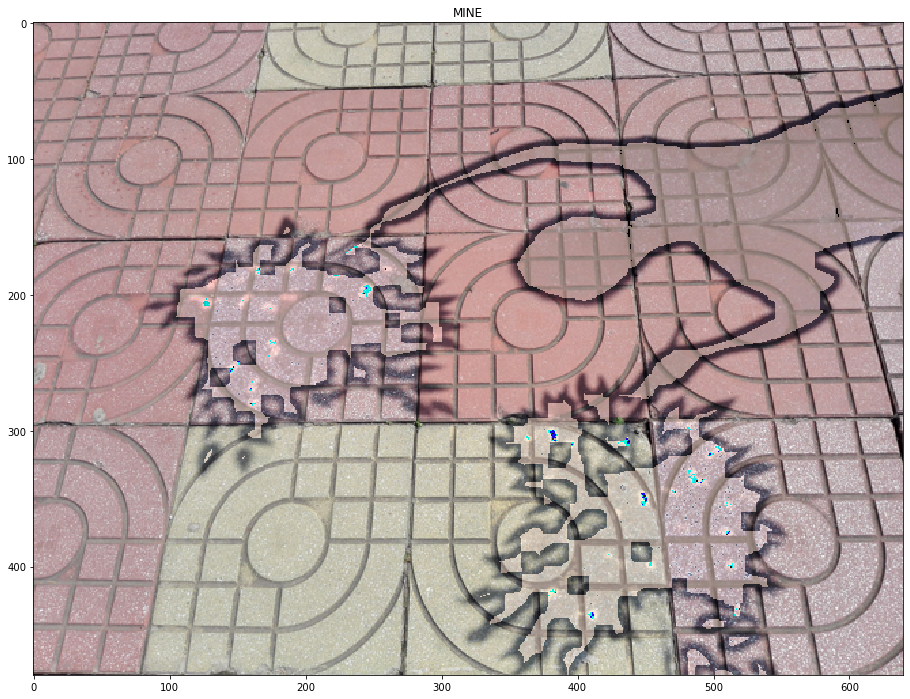

12.557166108231598 [1.         0.47089183] [1.01141423 0.40761759] [1.         0.35819274]
12.557166108231598


In [4]:
import cv2
import os
from os import listdir
from os.path import isfile, join
from PIL import Image as Image
import numpy as np

from scipy.optimize import curve_fit

def relit(x, a, b):
    return (a * x.astype(np.float)/255 + b)*255



from matplotlib import pyplot as plt
def plshow(im,title='MINE'):
    if len(im.shape)>2:
  #      plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.imshow(im)
    else:
        plt.imshow(im,cmap='gray')
    plt.title(title)
    plt.rcParams["figure.figsize"] = (80,12)
    plt.show()

sd_path = 'dataset/ISTD/train_A'
mask_path = 'dataset/ISTD/train_B'
sdfree_path = 'dataset/ISTD/train_C_fixed_ours'

out = 'dataset/ISTD/train_params/'

if not os.path.exists(out):
    os.makedirs(out)

im_list  =  [f for f in listdir(sd_path) if isfile(join(sd_path, f)) and f.endswith('png')]
print(len(im_list),im_list[0])
kernel = np.ones((5,5),np.uint8)


def im_relit(Rpopt,Gpopt,Bpopt,dump):
    #some weird bugs with python
    sdim = dump.copy()
    sdim.setflags(write=1)
    sdim = sdim.astype(np.float)
    sdim[:,:,0] = (sdim[:,:,0]/255) * Rpopt[0] + Rpopt[1]
    sdim[:,:,1] = (sdim[:,:,1]/255) * Gpopt[0] + Gpopt[1]
    sdim[:,:,2] = (sdim[:,:,2]/255) * Bpopt[0] + Bpopt[1]
    sdim = sdim*255
   # print(np.amin(sdim),np.amax(sdim))
    return sdim

errors= []
for im in im_list[1:2]:
    sd = np.asarray(Image.open(join(sd_path,im)))
    mean_sdim = np.mean(sd,axis=2)
    
    mask_ori = np.asarray(Image.open(join(mask_path,im)))
    mask = cv2.erode(mask_ori ,kernel,iterations = 2)

    
    sdfree = np.asarray(Image.open(join(sdfree_path,im)))
    mean_sdfreeim = np.mean(sdfree,axis=2)
    
    #pixels for regression funtion
    i, j = np.where(np.logical_and(np.logical_and(np.logical_and(mask>=1,mean_sdim>5),mean_sdfreeim<230),np.abs(mean_sdim-mean_sdfreeim)>10))

    source = sd*0
    source[tuple([i,j])] = sd[tuple([i,j])] 
    target = sd*0
    target[tuple([i,j])]= sdfree[tuple([i,j])]
    
    R_s = source[:,:,0][tuple([i,j])]
    G_s = source[:,:,1][tuple([i,j])]
    B_s = source[:,:,2][tuple([i,j])]
    
    R_t = target[:,:,0][tuple([i,j])]
    G_t = target[:,:,1][tuple([i,j])]
    B_t = target[:,:,2][tuple([i,j])]
    
    c_bounds = [[1,-0.1],[10,0.5]]

    
    Rpopt, pcov = curve_fit(relit, R_s, R_t,bounds=c_bounds)
    Gpopt, pcov = curve_fit(relit, G_s, G_t,bounds=c_bounds)
    Bpopt, pcov = curve_fit(relit, B_s, B_t,bounds=c_bounds)
    
    
    relitim = im_relit(Rpopt,Gpopt,Bpopt,sd)
    
    final = sd.copy()
    final[tuple([i,j])] = relitim[tuple([i,j])]
    final[final>255] =255
    final[final<0] = 0

    plshow(final)
    
    error = np.mean(np.abs(relitim[tuple([i,j])].astype(np.float) - sdfree[tuple([i,j])]).astype(np.float))
    print(error,Rpopt,Gpopt,Bpopt)
    f = open(join(out,im+'.txt'),"a")
    f.write("%f %f %f %f %f %f"%(Rpopt[1],Rpopt[0],Gpopt[1],Gpopt[0],Bpopt[1],Bpopt[0]))
    f.close()
             
  #  print(error)
    errors.append(error)
                    
    
print(np.mean(errors))
#no bound - 8.55
#### y_bound ###error
#    0.5        8.86
#    0.1        15.692271753155671    
#    0.25       10.830443545867785
#    1          8.86